In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
%matplotlib inline

In [12]:
data=pd.read_csv("OnlineRetail.csv")
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Removing Null values

In [13]:
def count_na(data):
    na_count = pd.DataFrame(data.isnull().sum(), columns=['Count']).sort_values(by=['Count'], ascending=False)
    return na_count

In [14]:
count_na(data)

,Count
CustomerID,135080
Description,1454
InvoiceNo,0
StockCode,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


In [15]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate, format="%m-%d-%Y %H.%M")
data["CustomerID"] = data["CustomerID"].fillna(-9999)
data["CustomerID"] = data["CustomerID"].apply(lambda x: str(x)[:-2])
data["Description"] = data["Description"].fillna("Unkown")

In [16]:
count_na(data)

,Count
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [17]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Removing the outliers

In [18]:
print(data.shape)

data = data[ np.abs((data['UnitPrice']-data['UnitPrice'].mean())/data['UnitPrice'].std()) <= 3]
data = data[ np.abs((data['Quantity']-data['Quantity'].mean())/data['Quantity'].std()) <= 3]

data = data[data["UnitPrice"] >= 0 ]
data = data[data["InvoiceNo"].astype(str).str[0] != "C"]
data = data[data["InvoiceNo"].astype(str).str[0] != "A"]
data = data[data["Quantity"] > 0 ]

print(data.shape)

(541909, 8)
(530795, 8)


In [19]:
data.describe()

,Quantity,UnitPrice
count,530795.000000,530795.000000
mean,9.765493,3.472191
std,25.387942,6.961868
min,1.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,660.000000,293.000000


In [20]:
data['Revenue'] = data['Quantity']*data['UnitPrice']

data['Date'] = data['InvoiceDate'].dt.date
data['Day'] = data['InvoiceDate'].dt.day
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year
data['Hour'] = data['InvoiceDate'].dt.hour
data['Week'] = data['InvoiceDate'].dt.isocalendar().week
data['Minute'] = data['InvoiceDate'].dt.minute

In [21]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,Day,Month,Year,Hour,Week,Minute
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,1,12,2010,8,48,26
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,1,12,2010,8,48,26
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,1,12,2010,8,48,26


Globally

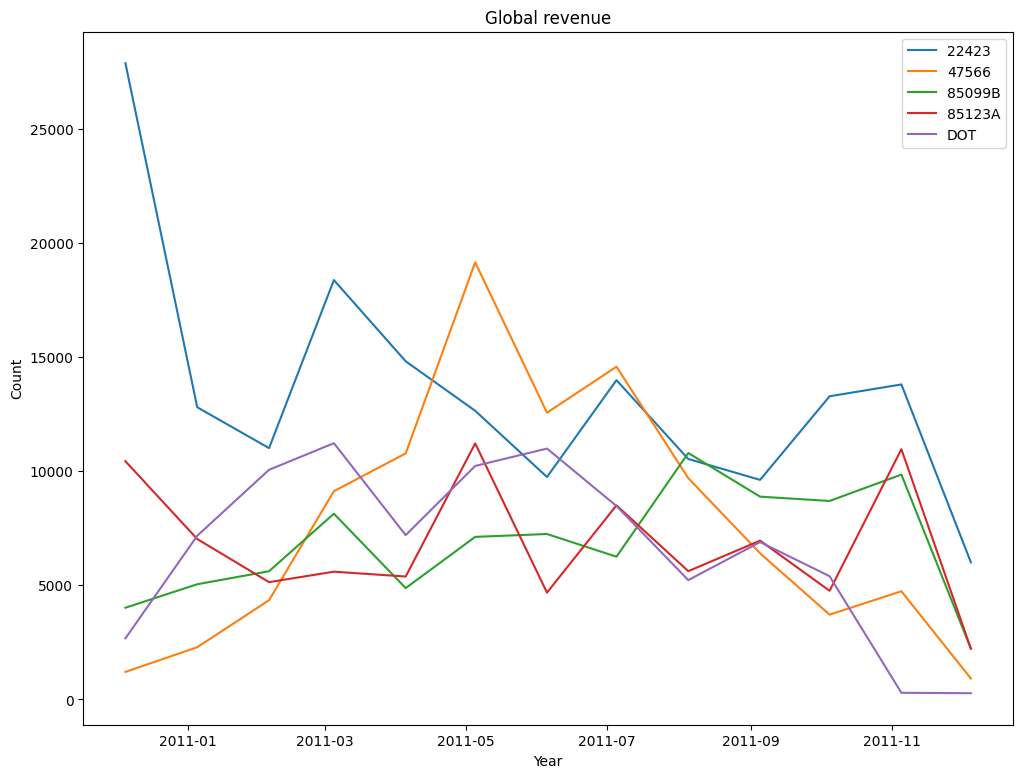

In [23]:
global_top = data[['Revenue', 'StockCode']].groupby(['StockCode']).sum().reset_index().sort_values(by='Revenue', ascending=False)['StockCode'].iloc[0:5]
fig, ax = plt.subplots(figsize=(12, 9))
for c in global_top:
    sales_globally = data[data['StockCode'] == c]
    sales_globally = sales_globally[['Year', 'Month', 'Revenue']].groupby(['Year', 'Month']).sum().reset_index()
    sales_globally['Day'] = 5
    sales_globally['Date'] = pd.to_datetime(sales_globally[['Year', 'Month', 'Day']])
    sales_globally = sales_globally.set_index('Date')
    sales_globally = sales_globally.drop(['Year', 'Month', 'Day'], axis=1)
    ax.plot(sales_globally.Revenue,label=c)
    ax.legend()
    ax.set_title('Global revenue')     
    ax.set_xlabel("Year")  
    ax.set_ylabel("Count")   

Country-Wise

<Figure size 640x480 with 0 Axes>

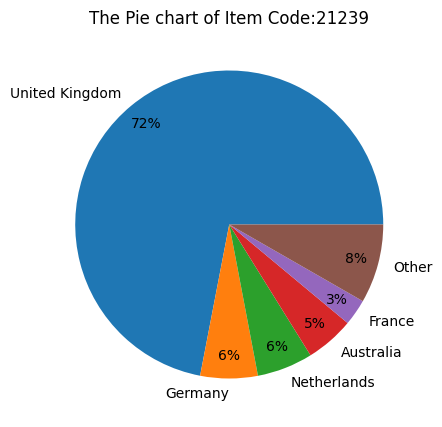

In [24]:
def top_stock(stockcode, top_n):
    stock = data[data['StockCode'] == stockcode].sort_values(['InvoiceDate'])
    stock['ValueCum'] = stock['Revenue'].cumsum()

    top_buyers = stock[['Revenue', 'CustomerID']].groupby(['CustomerID']).sum().sort_values(by='Revenue', ascending=False).reset_index()
    top_buyers = top_buyers[0:top_n]

    country_sales = stock[['Country', 'Revenue']].groupby(['Country']).sum().sort_values(by='Revenue', ascending=False)
    country_sales = ((country_sales/country_sales.sum())*100).round(2)
    country_sales = country_sales[0:int(top_n/2)]
    country_sales = pd.concat([country_sales,(pd.DataFrame(data=[100-country_sales.sum()], columns=['Revenue'], index=['Other'] ))])
    plt.clf()
    fig, ax = plt.subplots( figsize=(10, 5))
    ax.set_title(f"The Pie chart of Item Code:{stockcode}")
    ax.pie(country_sales['Revenue'], labels=country_sales.index,  autopct='%1.0f%%', pctdistance=0.85)
    plt.show()
    
stockcode=input("Enter the Stock Code:")
top_stock(stockcode, top_n = 10)  

Month-Wise

<Figure size 640x480 with 0 Axes>

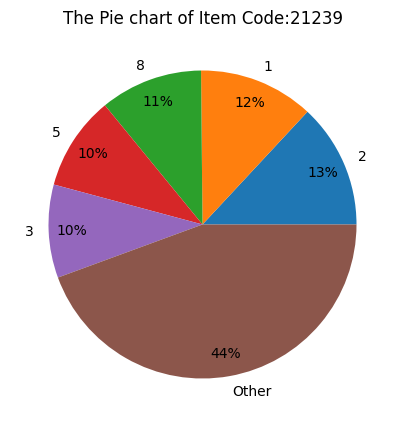

In [27]:
def top_stock(stockcode, top_n):
    stock = data[data['StockCode'] == stockcode].sort_values(['InvoiceDate'])
    stock['ValueCum'] = stock['Revenue'].cumsum()

    top_buyers = stock[['Revenue', 'CustomerID']].groupby(['CustomerID']).sum().sort_values(by='Revenue', ascending=False).reset_index()
    top_buyers = top_buyers[0:top_n]

    monthly_sales = stock[['Month', 'Revenue']].groupby(['Month']).sum().sort_values(by='Revenue', ascending=False)
    monthly_sales = ((monthly_sales/monthly_sales.sum())*100).round(2)
    monthly_sales = monthly_sales[0:int(top_n/2)]
    monthly_sales = pd.concat([monthly_sales,(pd.DataFrame(data=[100-monthly_sales.sum()], columns=['Revenue'], index=['Other'] ))])
    plt.clf()
    fig, ax = plt.subplots( figsize=(10, 5))
    ax.set_title(f"The Pie chart of Item Code:{stockcode}")
    ax.pie(monthly_sales['Revenue'], labels=monthly_sales.index,  autopct='%1.0f%%', pctdistance=0.85)
    plt.show()
    
stockcode=input("Enter the Stock Code:")
top_stock(stockcode, top_n = 10) 